In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers
from tensorflow.keras import losses
import re
import string
import matplotlib.pyplot as plt

print("Imports successful!")

Imports successful!


In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/dsaa-6100-movie-review-classification.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:

import pandas as pd
from sklearn.model_selection import train_test_split

# Đọc dữ liệu từ tệp CSV
data = pd.read_csv('movie_reviews/movie_reviews.csv')

# Tạo tập dữ liệu TensorFlow từ tập huấn luyện và tập kiểm tra
train_dataset = tf.data.Dataset.from_tensor_slices((data['text'].values, data['label'].values))

# Xáo trộn và đóng gói dữ liệu
BUFFER_SIZE = 40000
BATCH_SIZE = 8192

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Take one batch from the dataset and print out the first three datapoints in the batch
for text_batch, label_batch in train_dataset.take(1):
    for i in range(3):
        print(f"Text:\n {text_batch.numpy()[i]}")
        print(f"Label: {label_batch.numpy()[i]}\n")

Text:
 b'Thats right you heard me this movie is a freaking ABOMINATION First off the band who the hell is going to go see or listen to a band called THE NAKED BROTHERS BAND Not only is the name terrible but so are the musicians they cant even play anything Also the lead singer sounds more girly than Geddy Lee and even more his voice is horrible Not only are they terrible musicians but theyre terrible actors Led by a crappy director and thin plot this has got to be the dumbest movie ever I wish this website would let you use a vote of ZERO OR BELOW out of 10 because giving this filth a 110 is being WAY too generous Im not sure that you can call this a comedy film If youre looking for comedy with music go to that Weird Al Yankovic guy cause he does it a whole lot better than these untalented tweens'
Label: 0

Text:
 b'This has been put out on the DVD market by Alpha and its for diehard Boris Karloff fans like moi only Its not a horror flick but a drama where Boris is a struggling scienti

In [ ]:
# Set the maximum number of words
max_features = 40000
# Define the custom standardization function
def custom_standardization(input_data):
    # Convert all text to lowercase
    lowercase = tf.strings.lower(input_data)
    # Remove HTML tags
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    # Remove punctuation
    replaced = tf.strings.regex_replace(
        stripped_html,
        '[%s]' % re.escape(string.punctuation),
        ''
        )
    replaced = tf.strings.regex_replace(replaced, '\$\w*', '')
    replaced = tf.strings.regex_replace(replaced, '^RT[\s]+', '')
    replaced = tf.strings.regex_replace(replaced, 'https?:\/\/.*[\r\n]*', '')
    replaced = tf.strings.regex_replace(replaced, '#', '')
    return replaced

# Create a layer that you can use to convert text to vectors
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=250)

In [ ]:
# Build the vocabulary
train_text = train_dataset.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

# Print out the vocabulary size
print(f"Vocabulary size: {len(vectorize_layer.get_vocabulary())}")

Vocabulary size: 40000


In [ ]:
vectorize_layer.get_vocabulary()[32744]

'smallish'

In [ ]:
# Define the final function that you will use to vectorize the text.
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

# Get one batch and select the first datapoint
text_batch, label_batch = next(iter(train_dataset))
first_review, first_label = text_batch[0], label_batch[0]

# Show the raw data
print(f"Review:\n{first_review}")
print(f"\nLabel: {first_label}")
# Show the vectorized data
print(f"\nVectorized review\n{vectorize_text(first_review, first_label)}")

Review:
b'Despite its budget limitations this is a great film proof that effort and imagination can overcome lack of cash The opening in which cavepaintings seem to show how some dinosaurs at least survived into the age of human beings is a nice red herring After that a meteor comes down into a lake and causes heat which in turn causes the hatching of a frozen dinosaur egg maybe the cavepaintings suggest instead that this isnt the first time such a thing has happened When the prehistoric beast appears its a wellanimated Plesiosaur which is soon causing disappearances in the local area Alright so its not Jurassic Park but its still genuine entertainment for fans of monster movies'

Label: 1

Vectorized review
(<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  461,    29,   396,  5798,    11,     7,     4,    80,    19,
         3025,    12,   782,     3,  1585,    68,  3161,   577,     5,
         2157,     2,   607,     8,    62,     1,   303,     6,   118,
           85,    46

In [ ]:
train_ds = train_dataset.map(vectorize_text)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

# **Mô hình neural network cơ bản(Simple Sequence Model)**

In [ ]:
embedding_dim = 16


model = tf.keras.Sequential([
    layers.Embedding(max_features, embedding_dim),
    layers.GlobalAveragePooling1D(),
    layers.Dense(embedding_dim, activation='PReLU'),
    layers.Dense(1, activation='sigmoid')
])

# Biên dịch mô hình
model.compile(loss=losses.BinaryCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=['accuracy'])

# In ra thông tin tổng quan của mô hình
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          640000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                288       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 640,305
Trainable params: 640,305
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Huấn luyện mô hình
epochs = 150
history = model.fit(
    train_ds,
    epochs=epochs,
    verbose=2
)

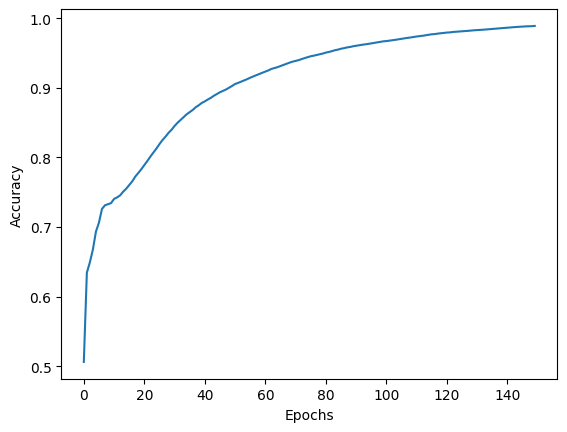

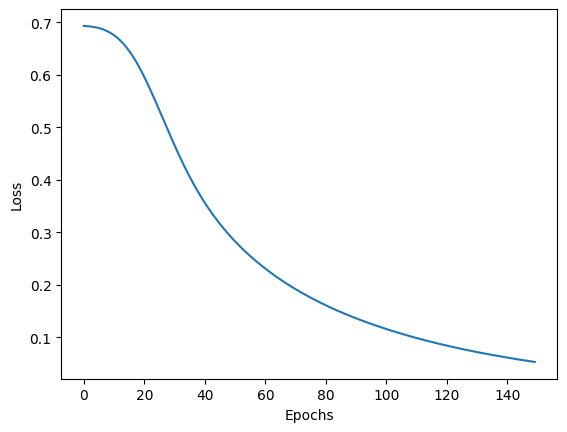

In [ ]:
def plot_metrics(history, metric):
    plt.plot(history.history[metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric.title())
    plt.show()

plot_metrics(history, "accuracy")
plot_metrics(history, "loss")

# **Mô hình simple RNN**

In [ ]:
embedding_dim = 16


model_simple_RNN = tf.keras.Sequential([
    layers.Embedding(max_features, embedding_dim),
    layers.SimpleRNN(32,activation='tanh',return_sequences=False),
    layers.Dense(1, activation='sigmoid')
])

# Biên dịch mô hình
model_simple_RNN.compile(loss=losses.BinaryCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=['accuracy'])

# In ra thông tin tổng quan của mô hình
model_simple_RNN.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 16)          640000    
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                1568      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 641,601
Trainable params: 641,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Huấn luyện mô hình
epochs = 75
history = model_simple_RNN.fit(
    train_ds,
    epochs=epochs,
    verbose=2
)

Epoch 1/75
5/5 - 9s - loss: 0.6952 - accuracy: 0.4981 - 9s/epoch - 2s/step
Epoch 2/75
5/5 - 10s - loss: 0.6874 - accuracy: 0.5468 - 10s/epoch - 2s/step
Epoch 3/75
5/5 - 10s - loss: 0.6766 - accuracy: 0.5873 - 10s/epoch - 2s/step
Epoch 4/75
5/5 - 7s - loss: 0.6599 - accuracy: 0.6274 - 7s/epoch - 1s/step
Epoch 5/75
5/5 - 9s - loss: 0.6377 - accuracy: 0.6716 - 9s/epoch - 2s/step
Epoch 6/75
5/5 - 12s - loss: 0.6165 - accuracy: 0.7032 - 12s/epoch - 2s/step
Epoch 7/75
5/5 - 10s - loss: 0.6120 - accuracy: 0.7145 - 10s/epoch - 2s/step
Epoch 8/75
5/5 - 15s - loss: 0.5985 - accuracy: 0.7258 - 15s/epoch - 3s/step
Epoch 9/75
5/5 - 7s - loss: 0.5495 - accuracy: 0.8086 - 7s/epoch - 1s/step
Epoch 10/75
5/5 - 10s - loss: 0.5164 - accuracy: 0.8248 - 10s/epoch - 2s/step
Epoch 11/75
5/5 - 7s - loss: 0.4998 - accuracy: 0.8437 - 7s/epoch - 1s/step
Epoch 12/75
5/5 - 7s - loss: 0.4583 - accuracy: 0.8699 - 7s/epoch - 1s/step
Epoch 13/75
5/5 - 11s - loss: 0.4150 - accuracy: 0.8983 - 11s/epoch - 2s/step
Epoch 1

In [ ]:
# Make a new sequential model using the vectorization layer and the model you just trained.
export_model = tf.keras.Sequential([
  vectorize_layer,
  model_simple_RNN]
)

# Compile the model
export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# **Mô hình GRU**

In [ ]:
embedding_dim = 16


model_GRU = tf.keras.Sequential([
    layers.Embedding(max_features, embedding_dim),
    layers.GRU(32,activation='tanh',return_sequences=False),
    layers.Dense(1, activation='sigmoid')
])

# Biên dịch mô hình
model_GRU.compile(loss=losses.BinaryCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=['accuracy'])

# In ra thông tin tổng quan của mô hình
model_GRU.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 16)          640000    
                                                                 
 gru_1 (GRU)                 (None, 32)                4800      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 644,833
Trainable params: 644,833
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Huấn luyện mô hình
epochs = 75
history = model_GRU.fit(
    train_ds,
    epochs=epochs,
    verbose=2
)

Epoch 1/75
5/5 - 35s - loss: 0.6932 - accuracy: 0.5013 - 35s/epoch - 7s/step
Epoch 2/75
5/5 - 32s - loss: 0.6928 - accuracy: 0.5075 - 32s/epoch - 6s/step
Epoch 3/75
5/5 - 25s - loss: 0.6925 - accuracy: 0.5226 - 25s/epoch - 5s/step
Epoch 4/75
5/5 - 24s - loss: 0.6920 - accuracy: 0.5342 - 24s/epoch - 5s/step
Epoch 5/75
5/5 - 22s - loss: 0.6912 - accuracy: 0.5458 - 22s/epoch - 4s/step
Epoch 6/75
5/5 - 24s - loss: 0.6902 - accuracy: 0.5498 - 24s/epoch - 5s/step
Epoch 7/75
5/5 - 24s - loss: 0.6888 - accuracy: 0.5532 - 24s/epoch - 5s/step
Epoch 8/75
5/5 - 25s - loss: 0.6867 - accuracy: 0.5565 - 25s/epoch - 5s/step
Epoch 9/75
5/5 - 26s - loss: 0.6835 - accuracy: 0.5602 - 26s/epoch - 5s/step
Epoch 10/75
5/5 - 23s - loss: 0.6785 - accuracy: 0.5646 - 23s/epoch - 5s/step
Epoch 11/75
5/5 - 22s - loss: 0.6697 - accuracy: 0.5681 - 22s/epoch - 4s/step
Epoch 12/75
5/5 - 22s - loss: 0.6481 - accuracy: 0.6029 - 22s/epoch - 4s/step
Epoch 13/75
5/5 - 22s - loss: 0.5668 - accuracy: 0.7128 - 22s/epoch - 4s/

In [ ]:
# Make a new sequential model using the vectorization layer and the model you just trained.
export_model = tf.keras.Sequential([
  vectorize_layer,
  model_GRU]
)

# Compile the model
export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# **Mô hình LSTM 2 chiều**

In [ ]:
embedding_dim = 32
from tensorflow.keras.layers import LSTM

model_bi_LSTM = tf.keras.Sequential([
    layers.Embedding(max_features,embedding_dim),
    layers.Bidirectional(LSTM(128,activation='tanh',return_sequences=False)),
    layers.Dense(1, activation='sigmoid')
])

# Biên dịch mô hình
model_bi_LSTM.compile(loss=losses.BinaryCrossentropy(from_logits=False),
              optimizer='adam',
              metrics=['accuracy'])

# In ra thông tin tổng quan của mô hình
model_bi_LSTM.summary()


In [ ]:
# Make a new sequential model using the vectorization layer and the model you just trained.
export_model = tf.keras.Sequential([
  vectorize_layer,
  model_bi_LSTM]
)

# Compile the model
export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# **Đưa ra dự đoán nhãn cho file test của Kaggle**

In [ ]:
import pandas as pd

# Đọc dữ liệu từ tệp CSV
data = pd.read_csv('test_data.csv')

# Lấy dữ liệu từ cột 'text'
examples = data['text'].tolist()

# Dự đoán nhãn cho dữ liệu
results = export_model.predict(examples, verbose=False)

# Tạo DataFrame mới với ID ban đầu và nhãn dự đoán
predicted_data = pd.DataFrame({
    'Id': data['Id'],  # Thay 'id' bằng tên cột ID thực tế trong tệp CSV
    'Category': [int(np.round(result[0])) for result in results]
})

# Lưu DataFrame vào tệp CSV mới
predicted_data.to_csv('/content/drive/MyDrive/predicted_labels.csv', index=False)


In [ ]:
predicted_data

,Id,Category
0,0,0
1,1,0
2,2,0
3,3,0
4,4,1
...,...,...
9995,9995,0
9996,9996,0
9997,9997,0
9998,9998,0
